In [473]:
from facetorch import FaceAnalyzer
from facetorch.analyzer.utilizer import LandmarkDrawerTorch
from omegaconf import OmegaConf
from torch.nn.functional import cosine_similarity
from typing import Dict
import operator
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np

## Configure

In [474]:
path_img_input="../Dataset/Labeled_Faces_in_the_Wild/lfw-deepfunneled/lfw-deepfunneled/Abdul_Majeed_Shobokshi/Abdul_Majeed_Shobokshi_0001.jpg"
path_img_output="test_output.jpg"
path_config="../Pre-processing/gpu.config.yml"


cfg = OmegaConf.load(path_config)

## Startup

In [475]:
# initialize
analyzer = FaceAnalyzer(cfg.analyzer)


{"asctime": "2024-10-07 23:07:22,968", "levelname": "INFO", "message": "Initializing FaceAnalyzer"}
{"asctime": "2024-10-07 23:07:22,968", "levelname": "INFO", "message": "Initializing BaseReader"}
{"asctime": "2024-10-07 23:07:22,977", "levelname": "INFO", "message": "Initializing FaceDetector"}
{"asctime": "2024-10-07 23:07:23,291", "levelname": "INFO", "message": "Initializing FaceUnifier"}
{"asctime": "2024-10-07 23:07:23,301", "levelname": "INFO", "message": "Initializing FacePredictor objects"}
{"asctime": "2024-10-07 23:07:23,301", "levelname": "INFO", "message": "Initializing FacePredictor embed"}
{"asctime": "2024-10-07 23:07:23,588", "levelname": "INFO", "message": "Initializing FacePredictor verify"}
{"asctime": "2024-10-07 23:07:25,540", "levelname": "INFO", "message": "Initializing FacePredictor au"}
{"asctime": "2024-10-07 23:07:25,991", "levelname": "INFO", "message": "Initializing FacePredictor va"}
{"asctime": "2024-10-07 23:07:26,026", "levelname": "INFO", "message": 

## Inference

In [476]:
response = analyzer.run(
        path_image=path_img_input,
        batch_size=cfg.batch_size,
        fix_img_size=cfg.fix_img_size,
        return_img_data=cfg.return_img_data,
        include_tensors=cfg.include_tensors,
        path_output=path_img_output,
    )


{"asctime": "2024-10-07 23:07:26,274", "levelname": "INFO", "message": "Running FaceAnalyzer"}
{"asctime": "2024-10-07 23:07:26,275", "levelname": "INFO", "message": "Reading image", "input": "../Dataset/Labeled_Faces_in_the_Wild/lfw-deepfunneled/lfw-deepfunneled/Abdul_Majeed_Shobokshi/Abdul_Majeed_Shobokshi_0001.jpg"}
{"asctime": "2024-10-07 23:07:26,279", "levelname": "INFO", "message": "Detecting faces"}
{"asctime": "2024-10-07 23:07:26,702", "levelname": "INFO", "message": "Number of faces: 1"}
{"asctime": "2024-10-07 23:07:26,702", "levelname": "INFO", "message": "Unifying faces"}
{"asctime": "2024-10-07 23:07:26,703", "levelname": "INFO", "message": "Predicting facial features"}
{"asctime": "2024-10-07 23:07:26,704", "levelname": "INFO", "message": "Running FacePredictor: embed"}
{"asctime": "2024-10-07 23:07:26,775", "levelname": "INFO", "message": "Running FacePredictor: verify"}
{"asctime": "2024-10-07 23:07:34,185", "levelname": "INFO", "message": "Running FacePredictor: au"}

In [477]:
response.faces[0].tensor.shape

torch.Size([3, 380, 380])

## Output image

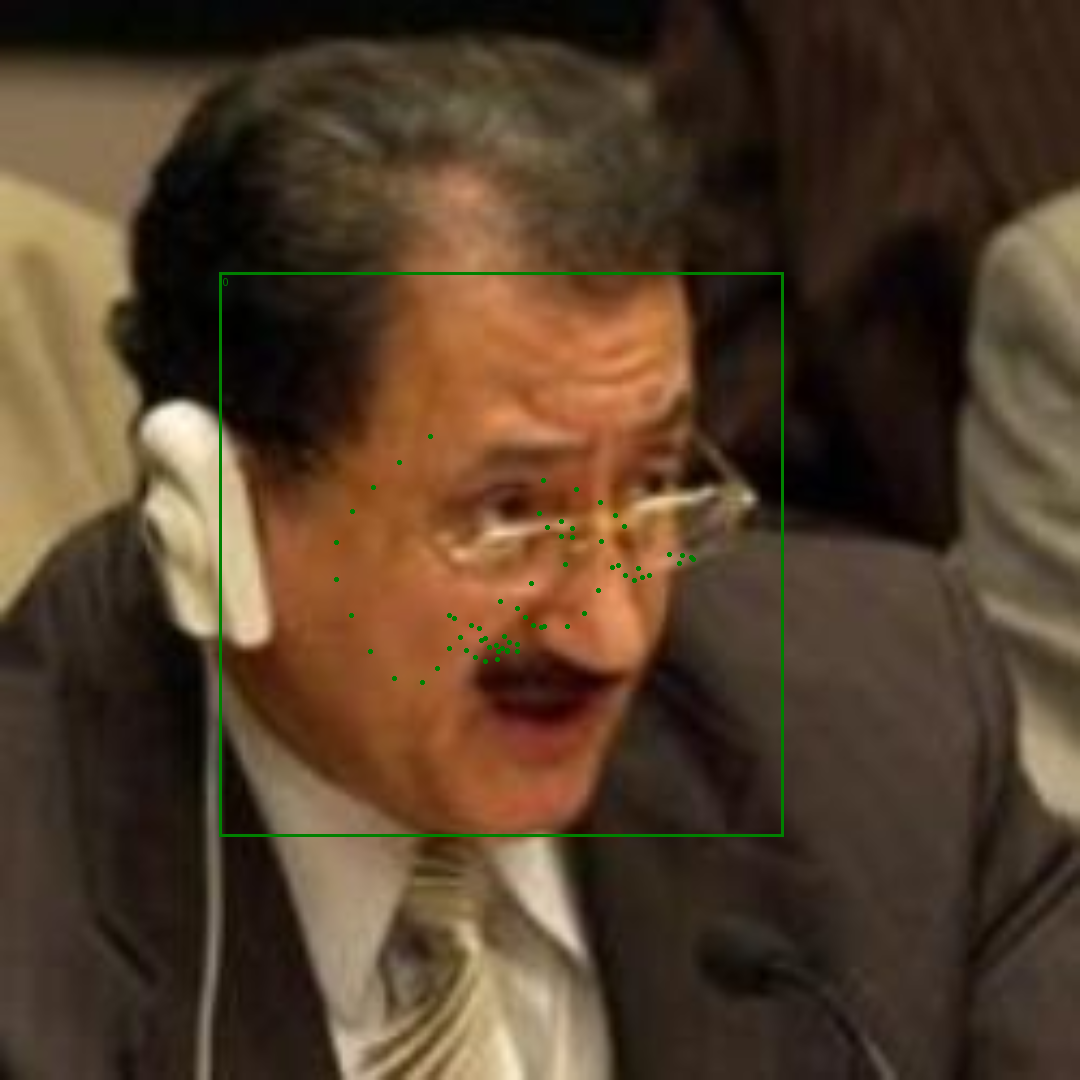

In [478]:
pil_image = torchvision.transforms.functional.to_pil_image(response.img)
pil_image

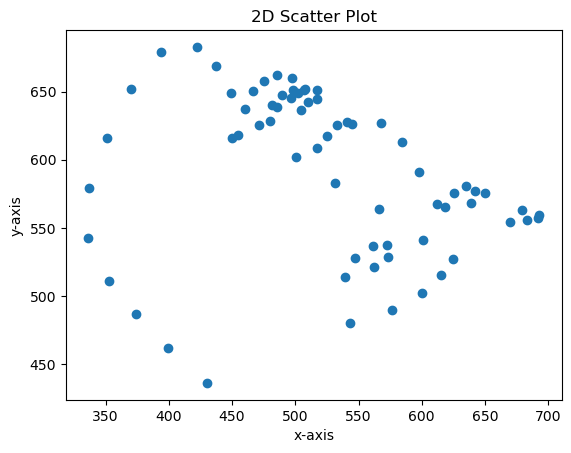

In [479]:


pts = [face.preds["align"].other["lmk3d"].cpu() for face in response.faces]


# data = normalize(pts[0])
data = pts[0]

norm = np.linalg.norm(data)  # Calculate the L2 norm of the data
normalized_data = data / norm

# Extract the first two columns for 2D scatter plot
x = data[0,:]  # First column (x)
y = data[1,:]  # Second column (y)
z = data[2,:]  # Third column (z)

# Create the 2D scatter plot
plt.scatter(x, y)
# print(len(z))

# Add labels and title
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('2D Scatter Plot')

# Display the plot
plt.show()


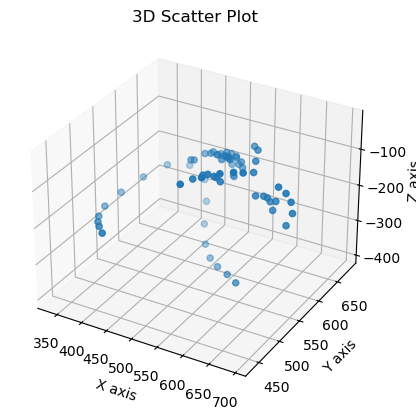

In [480]:
data = pts[0]

# Extract the three columns for 3D scatter plot
x = data[0,:]  # First column (x)
y = data[1,:]  # Second column (y)
z = data[2,:]  # Third column (z)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Create the 3D scatter plot
ax.scatter(x, y, z)

# Add labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.title('3D Scatter Plot')

# Display the plot
plt.show()

## Rotation

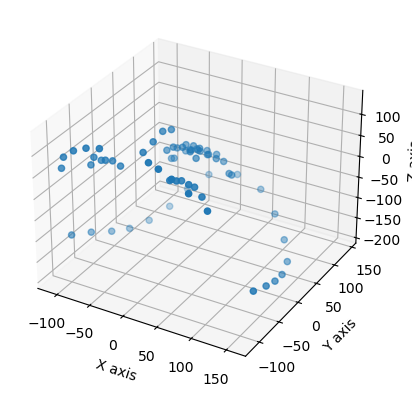

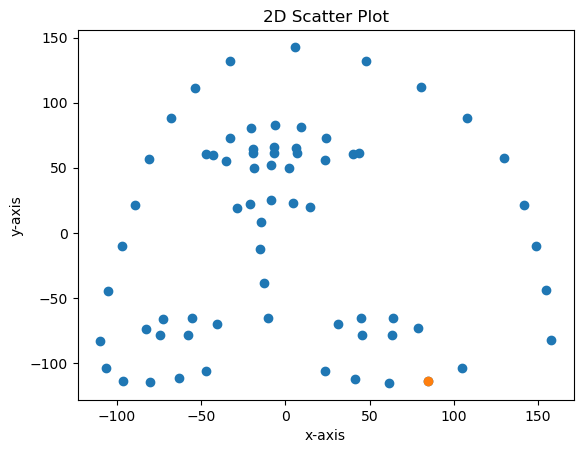

In [481]:
from scipy.spatial.transform import Rotation as R
data = pts[0]

x = data[0, :]
y = data[1, :]
z = data[2, :]

face_tensor = torch.stack([x, y, z], dim=1).to('cuda:0')
# Väldigt hustler-lösning, får inte skiten att se bra ut

sum_vectors = torch.sum(face_tensor, dim=0)
centroid = sum_vectors / face_tensor.shape[0]
face_tensor_orgin = (face_tensor - centroid).cpu().numpy()


P1 = face_tensor_orgin[0]
P2 = face_tensor_orgin[16]

y1 = P1[1]
y2 = P2[1]

while abs(y1 - y2) > 1:
    r = R.from_euler('z', -0.1, degrees=True)
    face_tensor_orgin =  face_tensor_orgin @ r.as_matrix().T
    P1 = face_tensor_orgin[0]
    P2 = face_tensor_orgin[16]
    y1 = P1[1]
    y2 = P2[1]



### VET INTE OM DETTA FUNKAR ###
z1 = P1[2]
z2 = P2[2]
x = face_tensor_orgin[33][0]

i = 0.1
if x > 0:
    i = -0.1

while abs(z1 - z2) > 1:
    r = R.from_euler('y', i, degrees=True)
    face_tensor_orgin =  face_tensor_orgin @ r.as_matrix().T
    P1 = face_tensor_orgin[0]
    P2 = face_tensor_orgin[16]
    z1 = P1[2]
    z2 = P2[2]

### VET INTE OM DETTA FUNKAR SLUT ###

if face_tensor_orgin[25][1] > 0:
    r = R.from_euler('z', 180, degrees=True)
    face_tensor_orgin =  face_tensor_orgin @ r.as_matrix().T

x = face_tensor_orgin[:,0]  # First column (x)
y = face_tensor_orgin[:,1]  # Second column (y)
z = face_tensor_orgin[:,2]  # Third column (z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Create the 3D scatter plot
ax.scatter(x, y, z)


fig = plt.figure()


# Create the 3D scatter plot
plt.scatter(x, y)
plt.scatter(x[25], y[25])
# print(len(z))
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
# Add labels and title
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('2D Scatter Plot')

# Display the plot
plt.show()





## FFT

[[-4.13613702 -3.94198736 -3.35925277 -4.12930845 -3.75295225 -3.48515697
  -4.1041835  -5.172181   -3.23999586 -3.45718646 -5.3594372  -4.00005885
  -3.32832338 -3.69784224 -3.42668151 -3.00811094 -3.80220367 -5.52657082
  -3.31026701 -2.96049101 -4.31971889 -3.11213433 -3.39380731 -3.09665065
  -3.63298486 -2.34032508 -2.24829713 -2.85380747 -2.26320184 -1.9592537
  -2.55415279 -0.68002406 -1.67306771 -0.48987744 -0.37924441 -0.48987744
  -1.67306771 -0.68002406 -2.55415279 -1.9592537  -2.26320184 -2.85380747
  -2.24829713 -2.34032508 -3.63298486 -3.09665065 -3.39380731 -3.11213433
  -4.31971889 -2.96049101 -3.31026701 -5.52657082 -3.80220367 -3.00811094
  -3.42668151 -3.69784224 -3.32832338 -4.00005885 -5.3594372  -3.45718646
  -3.23999586 -5.172181   -4.1041835  -3.48515697 -3.75295225 -4.12930845
  -3.35925277 -3.94198736]
 [-4.50513544 -3.2728933  -3.60093137 -4.39995919 -3.60913414 -3.52448312
  -2.96836239 -3.44721249 -4.53148489 -3.69421655 -3.15842975 -3.37341093
  -4.7776999

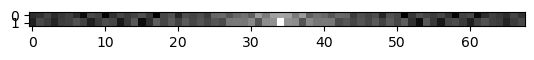

In [482]:
arr = response.faces[0].preds["align"].other["lmk3d"].cpu().numpy()

arrTwoDim = arr[:-1]

norm = np.linalg.norm(arrTwoDim)  # Calculate the L2 norm of the data
normalized_data = arrTwoDim / norm
transformed = np.fft.fft2(normalized_data)
transformedShifted = np.fft.fftshift(transformed)
logAbs = np.log(np.abs(transformedShifted))
print(logAbs)
plt.imshow(logAbs, cmap='gray')
plt.show()


[[-3.26687658 -3.05193699 -3.51858759 -3.30435316 -3.75813007 -2.80953274
  -3.23611408 -3.49053841 -3.90958858 -3.07020717 -3.66958761 -3.34431167
  -3.91230562 -2.46077364 -2.3854069  -3.77827139 -2.67843042 -2.90886225
  -2.96229883 -3.772496   -2.49222094 -2.54745274 -2.71484708 -3.35297757
  -3.26558223 -2.37801286 -2.32966367 -1.24810596 -1.45634207 -1.26463214
  -1.15506988 -0.60755418 -0.93011444 -0.38399989  1.98673233 -0.94711924
  -2.24807465 -0.91161595 -1.09420656 -2.15530941 -2.06669983 -1.49515557
  -2.03401    -2.57619992 -5.03262353 -2.19674767 -2.73185483 -4.06000398
  -2.8069768  -2.27717088 -3.76912797 -2.89596583 -3.05903232 -2.8069583
  -3.13216578 -2.98427667 -2.9406121  -3.3506816  -3.7113756  -3.00515682
  -2.87192139 -3.69747811 -2.70678647 -3.73429027 -3.90002309 -3.96740207
  -2.75556471 -3.41633136]
 [-2.96035801 -3.49701724 -4.87589369 -3.64704972 -3.38106461 -4.13950992
  -3.44941751 -3.03052661 -3.55061282 -4.20284265 -3.22907415 -3.17170642
  -4.1903745

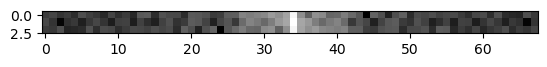

In [483]:
arr = response.faces[0].preds["align"].other["lmk3d"].cpu().numpy()

norm = np.linalg.norm(arr)  # Calculate the L2 norm of the data
normalized_data = arr / norm
transformed = np.fft.fftn(normalized_data)
transformedShifted = np.fft.fftshift(transformed)
logAbs = np.log(np.abs(transformedShifted))
print(logAbs)
plt.imshow(logAbs, cmap='gray')
plt.show()
